**Detailed Look at Music Sales and Customer Actions with the Chinook Database**

This project analyzed the Chinook Database, focusing on top-selling artists, customer purchase patterns, genre popularity, sales trends, customer lifetime value (CLV), and market basket analysis. 

The project aimed to comprehensively understand customer behavior and market dynamics within the music industry through these analyses.


**To achieve this, I will follow the below steps;**

**Step 1: Importing the necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

**Step 2: Connecting my dataset**

In [2]:
path_to_file = r"C:\Users\ANASTASIA\Desktop\Capstone Projects\chinook.db"

Chinook_data = sqlite3.connect(path_to_file)

**Step 3: Understanding the table schema**
    
    1. Getting the tables

In [3]:
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(tables_query, Chinook_data)

print("Tables in the database:\n", tables)

Tables in the database:
                name
0            albums
1   sqlite_sequence
2           artists
3         customers
4         employees
5            genres
6          invoices
7     invoice_items
8       media_types
9         playlists
10   playlist_track
11           tracks
12     sqlite_stat1


2. Understanding the relationships between tables

In [4]:
def get_table_schema(table_name):
    schema_query = f"PRAGMA table_info({table_name});"
    return pd.read_sql(schema_query, Chinook_data)

# Getting the foreign keys of our table
def get_foreign_keys(table_name):
    fk_query = f"PRAGMA foreign_key_list({table_name});"
    return pd.read_sql(fk_query, Chinook_data)

In [5]:
# Iterating the tables to print table schema and foreign keys for each table

for table in tables['name']:
    print(f"\nSchema for table '{table}':")
    print(get_table_schema(table))
    
    foreign_keys = get_foreign_keys(table)
    if not foreign_keys.empty:
        print(f"\nForeign keys for table '{table}':")
        print(foreign_keys)
    else:
        print(f"\nTable '{table}' does not contain any foreign keys.")


Schema for table 'albums':
   cid      name           type  notnull dflt_value  pk
0    0   AlbumId        INTEGER        1       None   1
1    1     Title  NVARCHAR(160)        1       None   0
2    2  ArtistId        INTEGER        1       None   0

Foreign keys for table 'albums':
   id  seq    table      from        to  on_update  on_delete match
0   0    0  artists  ArtistId  ArtistId  NO ACTION  NO ACTION  NONE

Schema for table 'sqlite_sequence':
   cid  name type  notnull dflt_value  pk
0    0  name             0       None   0
1    1   seq             0       None   0

Table 'sqlite_sequence' does not contain any foreign keys.

Schema for table 'artists':
   cid      name           type  notnull dflt_value  pk
0    0  ArtistId        INTEGER        1       None   1
1    1      Name  NVARCHAR(120)        0       None   0

Table 'artists' does not contain any foreign keys.

Schema for table 'customers':
    cid          name          type  notnull dflt_value  pk
0     0    Cust

**Summary:** From the details above, these relationships form a well-connected database where artists create albums, albums contain tracks, customers purchase tracks through invoices, and invoices detail the purchased items.

**Step 4: Checking the Data Structure for possible dirty data**

In [6]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables_df = pd.read_sql_query(query, Chinook_data)
table_names = tables_df['name'].tolist()

dataframes = {table_name: pd.read_sql_query(f"SELECT * FROM {table_name}", Chinook_data) for table_name in table_names}

# Closing my connection
Chinook_data.close()

# Check for missing values, duplicates, and verify data types for each DataFrame to enhance data cleaning
for table_name, df in dataframes.items():
    print(f"--- {table_name} DataFrame ---")
    df.info()
    print(df.head())
    print("\nMissing values:\n", df.isnull().sum())
    print("\nDuplicates:\n", df.duplicated().sum())
    print("\nData Types:\n", df.dtypes)
    print("\n----------------------------\n")

--- albums DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AlbumId   347 non-null    int64 
 1   Title     347 non-null    object
 2   ArtistId  347 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ KB
   AlbumId                                  Title  ArtistId
0        1  For Those About To Rock We Salute You         1
1        2                      Balls to the Wall         2
2        3                      Restless and Wild         2
3        4                      Let There Be Rock         1
4        5                               Big Ones         3

Missing values:
 AlbumId     0
Title       0
ArtistId    0
dtype: int64

Duplicates:
 0

Data Types:
 AlbumId      int64
Title       object
ArtistId     int64
dtype: object

----------------------------

--- sqlite_sequence DataFrame ---
<class 'pandas.core.frame.DataFr

**Step 5: Data cleaning**
    
From the details above, we can see there are some missing values in some of the tables, therefore, we'll clean them before we start our analysis so we'll have an accurate results at the end.

In [7]:
# Cleaning of data. We'll replace empty categorical and numerical values with mode and median respectively.

def handle_missing_values(df):
    # Filling the missing values
    for column in df.columns:
        if df[column].dtype == 'object':
            # Fill missing values in categorical columns with the mode
            df[column].fillna(df[column].mode()[0], inplace=True)
        else:
            # Fill missing values in numerical columns with the median
            df[column].fillna(df[column].median(), inplace=True)
    return df

# Applying the function to each dataframe
cleaned_dataframes = {table_name: handle_missing_values(df.copy()) for table_name, df in dataframes.items()}

# Here, I just Verified that missing values have been treated
cleaned_missing_values = {table_name: df.isnull().sum() for table_name, df in cleaned_dataframes.items()}
print(cleaned_missing_values)

{'albums': AlbumId     0
Title       0
ArtistId    0
dtype: int64, 'sqlite_sequence': name    0
seq     0
dtype: int64, 'artists': ArtistId    0
Name        0
dtype: int64, 'customers': CustomerId      0
FirstName       0
LastName        0
Company         0
Address         0
City            0
State           0
Country         0
PostalCode      0
Phone           0
Fax             0
Email           0
SupportRepId    0
dtype: int64, 'employees': EmployeeId    0
LastName      0
FirstName     0
Title         0
ReportsTo     0
BirthDate     0
HireDate      0
Address       0
City          0
State         0
Country       0
PostalCode    0
Phone         0
Fax           0
Email         0
dtype: int64, 'genres': GenreId    0
Name       0
dtype: int64, 'invoices': InvoiceId            0
CustomerId           0
InvoiceDate          0
BillingAddress       0
BillingCity          0
BillingState         0
BillingCountry       0
BillingPostalCode    0
Total                0
dtype: int64, 'invoice_items':

**Step 5: Solving the use cases**

Chinook Database Use Cases:

1. Top-Selling Artists: Identify artists with the highest sales and analyze their sales trends over time.
    
2. Customer Purchase Patterns: Segment customers based on purchase behavior and identify key characteristics of high-value customers.
    
3. Genre Popularity: Determine the most popular music genres and analyze the change in genre popularity over different time periods.
    
4. Sales Over Time: Analyze monthly and yearly sales trends, including seasonal effects and significant sales events.
    
5. Customer Lifetime Value (CLV): Calculate the lifetime value of customers based on their purchase history and provide recommendations for improving customer retention.
    
6. Market Basket Analysis: Perform association rule mining to find common combinations of tracks or albums purchased together.

**Use Case 1:**
    
Top-Selling Artists: Identify artists with the highest sales and analyze their sales trends over time.

Top 5 Artists by Total Sales:
1. Iron Maiden, $138.60
2. U2, $105.93
3. Metallica, $90.09
4. Led Zeppelin, $86.13
5. Lost, $81.59


C:\Users\ANASTASIA\AppData\Local\Temp\ipykernel_13704\3431693569.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_sales_data['SaleMonth'] = pd.to_datetime(top_sales_data['SaleMonth'])


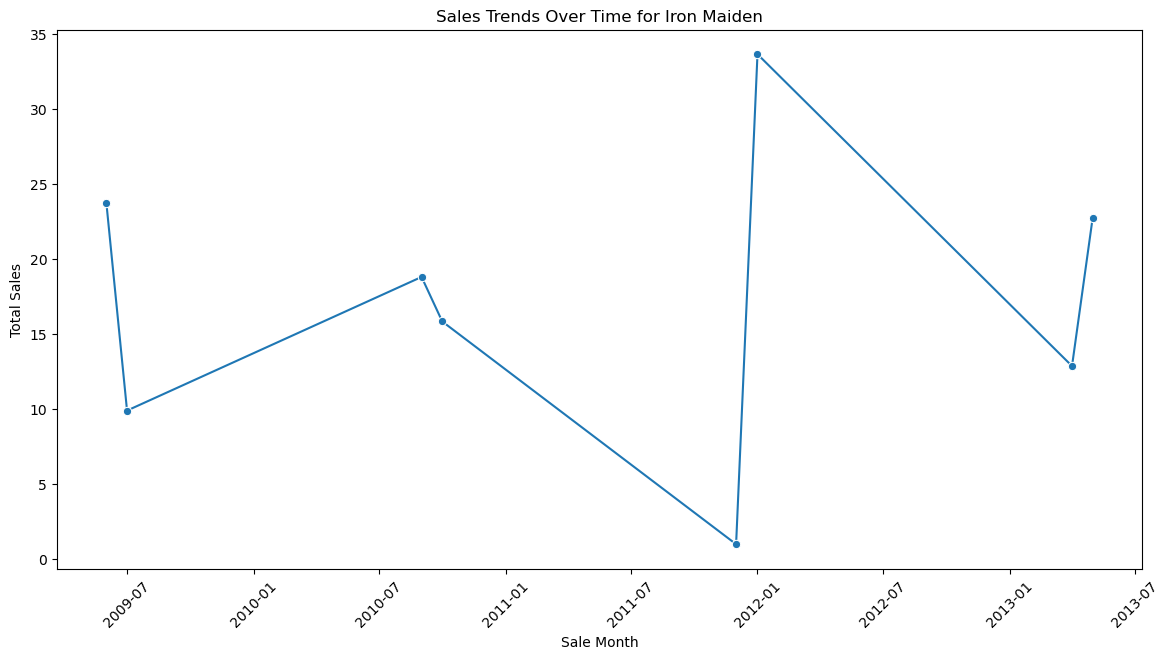

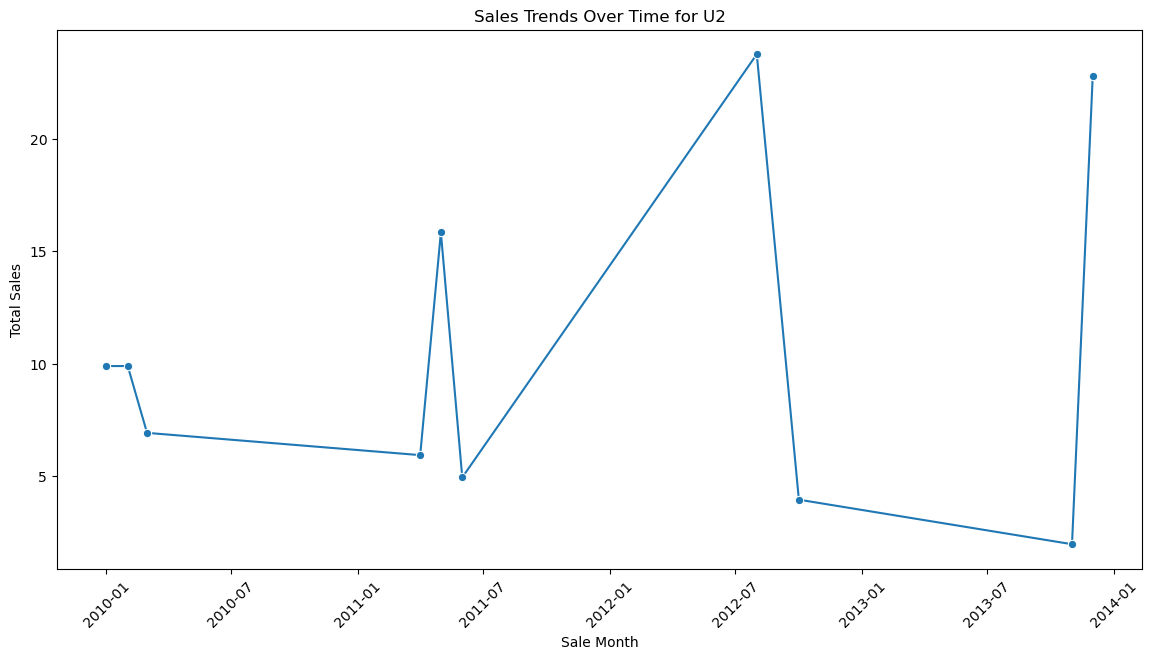

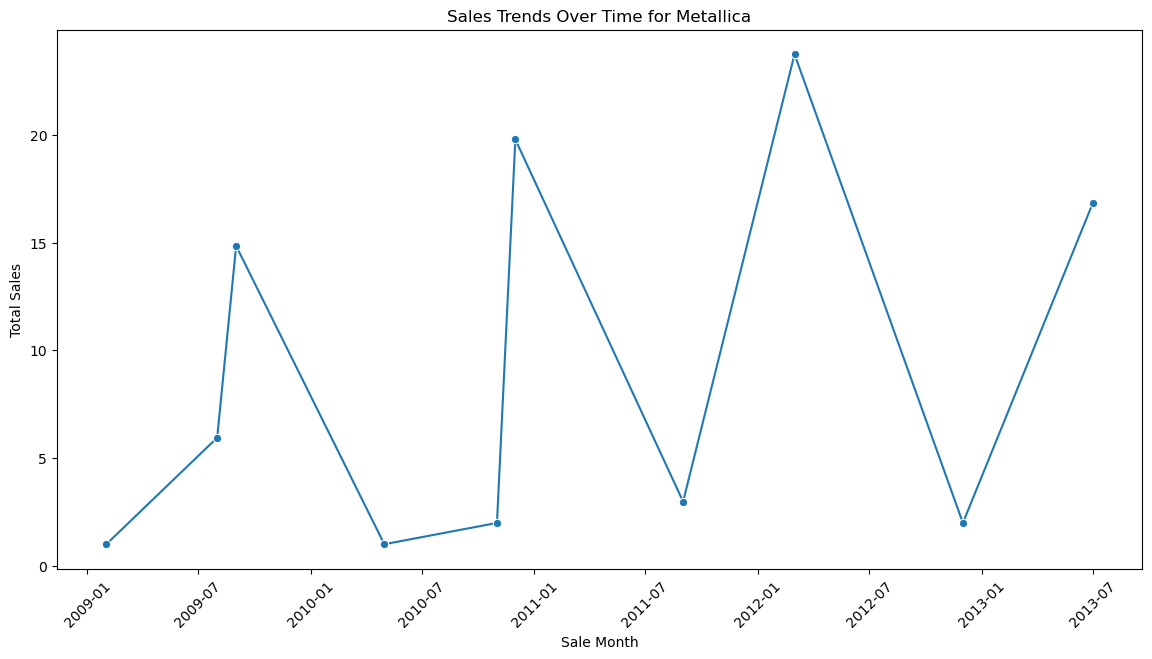

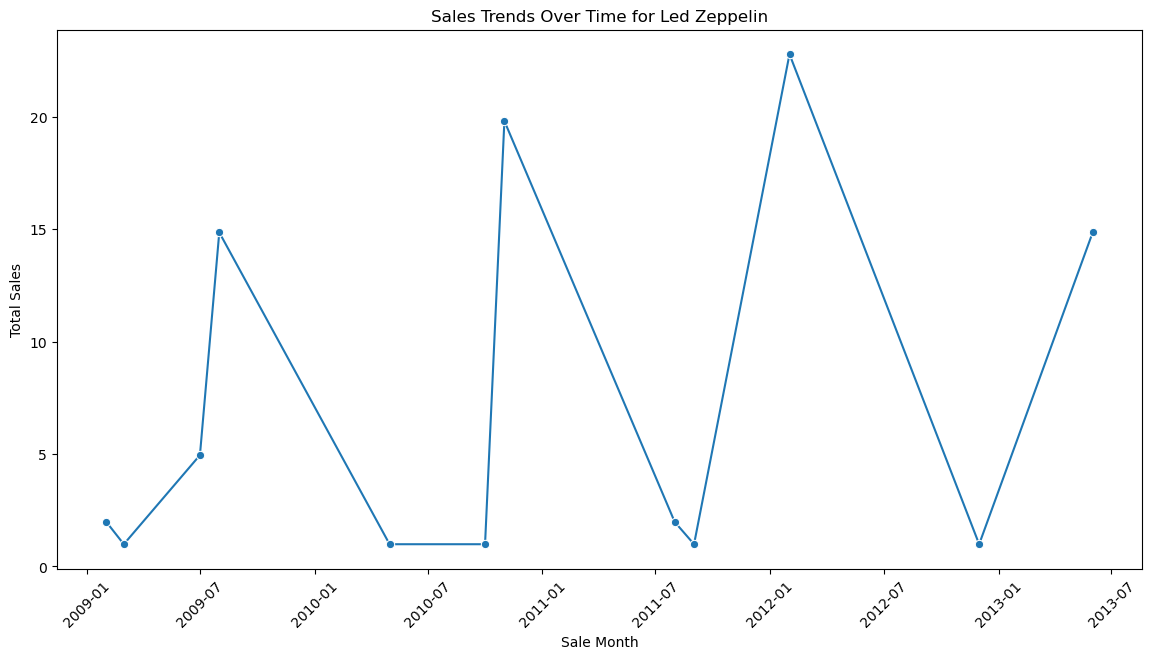

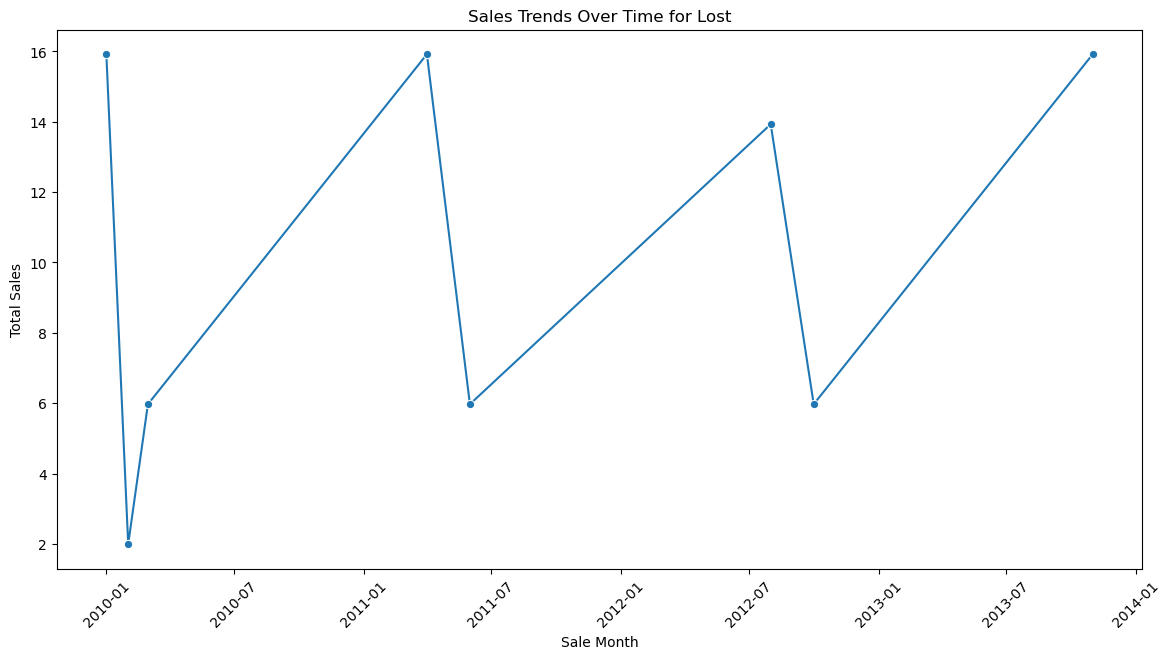

In [8]:
Chinook_data = sqlite3.connect(path_to_file) # Connecting my data.

# Query to get sales data for each artist including the month
query = '''
SELECT ar.Name AS Artist, SUM(ii.UnitPrice * ii.Quantity) AS TotalSales, strftime('%Y-%m', i.InvoiceDate) AS SaleMonth
FROM invoice_items ii
JOIN invoices i ON ii.InvoiceId = i.InvoiceId
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums al ON t.AlbumId = al.AlbumId
JOIN artists ar ON al.ArtistId = ar.ArtistId
GROUP BY ar.Name, SaleMonth
ORDER BY TotalSales DESC;
'''

# Loading my data into a DataFrame
sales_data = pd.read_sql_query(query, Chinook_data) 

# Closing my connection
Chinook_data.close()

# Getting the top 5 artists by total sales over all periods
top_artists = sales_data.groupby('Artist')['TotalSales'].sum().nlargest(5).index

# Printing the top artists sequentially
print("Top 5 Artists by Total Sales:")
for i, artist in enumerate(top_artists, start=1):
    total_sales = sales_data[sales_data['Artist'] == artist]['TotalSales'].sum()
    print(f"{i}. {artist}, ${total_sales:.2f}")

# Filtering the data for the top 5 artists
top_sales_data = sales_data[sales_data['Artist'].isin(top_artists)]

# Converting SaleMonth to datetime
top_sales_data['SaleMonth'] = pd.to_datetime(top_sales_data['SaleMonth'])

# Plotting sales trends for the top 5 artists individually
for artist in top_artists:
    artist_data = top_sales_data[top_sales_data['Artist'] == artist]
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=artist_data, x='SaleMonth', y='TotalSales', marker='o')
    plt.title(f'Sales Trends Over Time for {artist}')
    plt.xlabel('Sale Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.show()

**The combined trend analysis for the top 5 artists.**

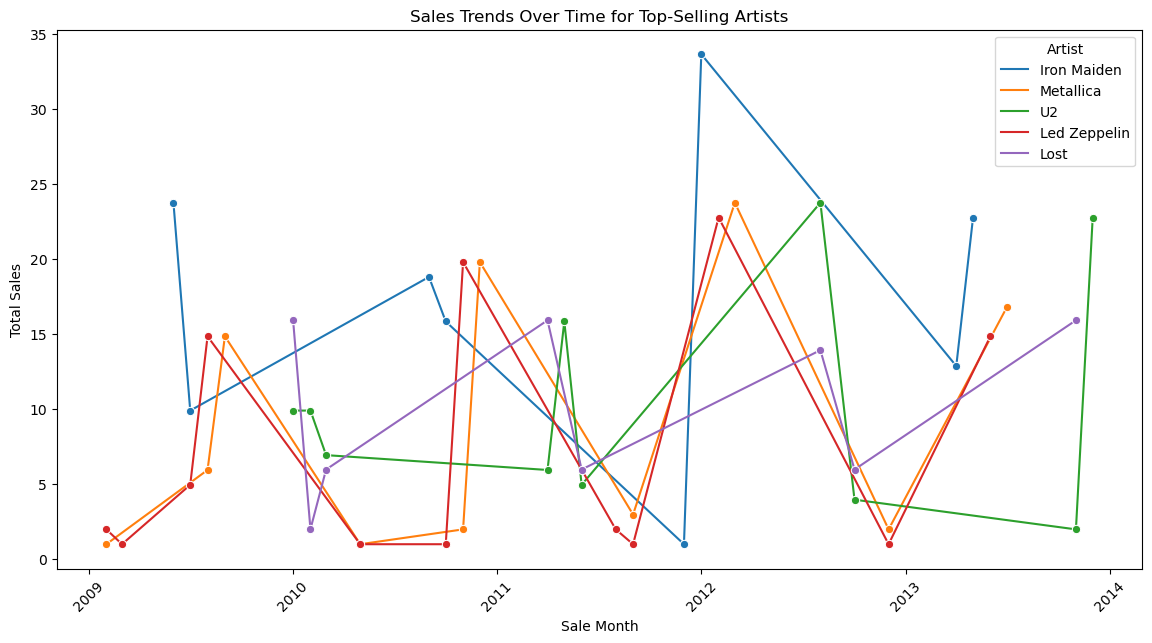

In [9]:
# Visualizing the sales trends over time for the top 5 artists
plt.figure(figsize=(14, 7))
sns.lineplot(data=top_sales_data, x='SaleMonth', y='TotalSales', hue='Artist', marker='o')
plt.title('Sales Trends Over Time for Top-Selling Artists')
plt.xlabel('Sale Month')
plt.ylabel('Total Sales')
plt.legend(title='Artist')
plt.xticks(rotation=45)
plt.show()

**Analysis of No. 1 Use Case.**

From the above analysis, the top 5 artists by total sales are;

1. Iron Maiden with a total sales of $138.60

2. U2 with a total sales of $105.93

3. Metallica with a total sales of $90.09

4. Led Zeppelin with a total sales of $86.13

5. Lost with a total sales of $81.59

Additionally, we visualized their sales over time individually, and jointly.

**Use Case 2:** 

Customer Purchase Patterns: Segment customers based on purchase behavior and identify key characteristics of high-value customers.
        
Step 1: Getting customers' purchase data.

In [10]:
# Connecting my data
Chinook_data = sqlite3.connect(path_to_file)

# Query to get customer purchase data
query = '''
SELECT c.CustomerId, c.FirstName, c.LastName, c.Country, SUM(ii.UnitPrice * ii.Quantity) AS TotalSpent, COUNT(i.InvoiceId) AS PurchaseCount
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalSpent DESC;
'''

# Loading my data into a DataFrame
customer_data = pd.read_sql_query(query, Chinook_data)

# Closing my connection
Chinook_data.close()

# Printing the DataFrame
print(customer_data.head())

   CustomerId FirstName    LastName         Country  TotalSpent  PurchaseCount
0           6    Helena        Holý  Czech Republic       49.62             38
1          26   Richard  Cunningham             USA       47.62             38
2          57      Luis       Rojas           Chile       46.62             38
3          45  Ladislav      Kovács         Hungary       45.62             38
4          46      Hugh    O'Reilly         Ireland       45.62             38


Step 2: Segmenting the customers based on their purchase behaviour.

In [11]:
# Here, I will set the high value customers as those who spent at least $40.62

threshold = 40.62

# Segmenting customers based on their TotalSpent
customer_data['Segment'] = np.where(customer_data['TotalSpent'] >= threshold, 'High-Value', 'Low-Value')

high_value_customers = customer_data[customer_data['Segment'] == 'High-Value']
low_value_customers = customer_data[customer_data['Segment'] == 'Low-Value']

print("-----High Value Customers:\n", high_value_customers)
print("-----Low Value Customers:\n", low_value_customers)

# Analyzing key characteristics of high-value customers
high_value_summary = high_value_customers.describe()
print("-----Summary of High-Value Customers:\n", high_value_summary)

-----High Value Customers:
     CustomerId  FirstName      LastName         Country  TotalSpent  \
0            6     Helena          Holý  Czech Republic       49.62   
1           26    Richard    Cunningham             USA       47.62   
2           57       Luis         Rojas           Chile       46.62   
3           45   Ladislav        Kovács         Hungary       45.62   
4           46       Hugh      O'Reilly         Ireland       45.62   
5           37       Fynn    Zimmermann         Germany       43.62   
6           24      Frank       Ralston             USA       43.62   
7           28      Julia       Barnett             USA       43.62   
8           25     Victor       Stevens             USA       42.62   
9            7     Astrid        Gruber         Austria       42.62   
10          44      Terhi    Hämäläinen         Finland       41.62   
11           5  František   Wichterlová  Czech Republic       40.62   
12          43   Isabelle       Mercier          

**Visual Representation**

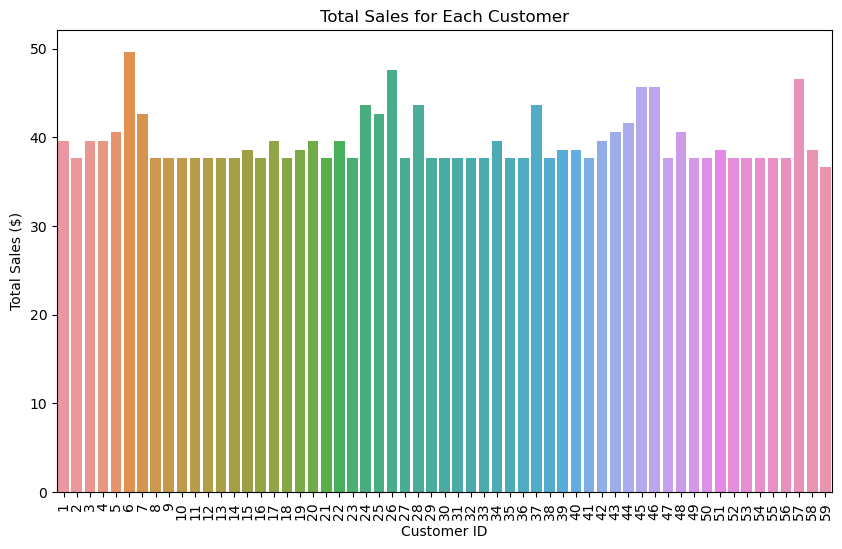

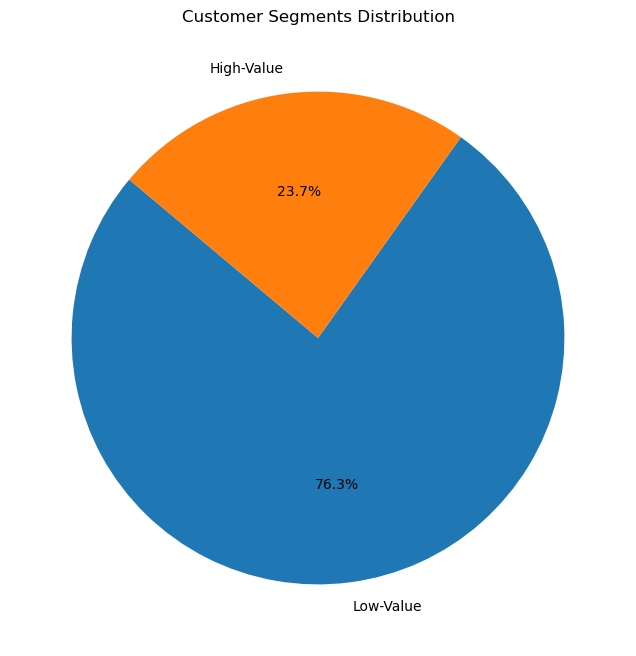

In [12]:
# Visualizing the Total Sales for Each Customer
plt.figure(figsize=(10, 6))
sns.barplot(data=customer_data, x='CustomerId', y='TotalSpent')
plt.title('Total Sales for Each Customer')
plt.xlabel('Customer ID')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=90)
plt.show()

# Visualizing the Distribution of Customer Segments
segment_counts = customer_data['Segment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Segments Distribution')
plt.show()

**Analysis of No. 2 Use Case.**

Key characteristics of high-value customers:

1. They have spent more than $40.00.

2. The average total spent by high-value customers is approximately $43.91.

Additionally, high-value customers made up 23.7% of the customers while low-value customers, that's customers that have total spent below our set threshold(40.62) made up 76.3% of the customers. 

**Use Case 3:** 
    
Genre Popularity: Determine the most popular music genres and analyze the change in genre popularity over different time periods.
    
Step 1:

In [13]:
# First, I'm going to get the popularity of each genre based on their total sales

# Connecting my database
Chinook_data = sqlite3.connect(path_to_file)

query = '''
SELECT g.Name AS Genre, SUM(ii.UnitPrice * ii.Quantity) AS TotalSales
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
JOIN invoice_items ii ON t.TrackId = ii.TrackId
GROUP BY g.Name
ORDER BY TotalSales DESC;
'''

# Loading my data into a DataFrame
genre_data = pd.read_sql_query(query, Chinook_data)

# Closing the connection
Chinook_data.close()

# Displaying the head of the DataFrame
print(genre_data.head())

                Genre  TotalSales
0                Rock      826.65
1               Latin      382.14
2               Metal      261.36
3  Alternative & Punk      241.56
4            TV Shows       93.53


Step 2:

In [14]:
# Secondly, I'm going to get their popularity over time

# Connecting my database
Chinook_data = sqlite3.connect(path_to_file)

query = """
SELECT g.Name as Genre, strftime('%Y', i.InvoiceDate) as Year, SUM(il.Quantity * il.UnitPrice) as TotalSales
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
JOIN invoice_items il ON t.TrackId = il.TrackId
JOIN invoices i ON il.InvoiceId = i.InvoiceId
GROUP BY g.Name, Year
ORDER BY Year, TotalSales DESC
"""
df_genre_sales_over_time = pd.read_sql_query(query, Chinook_data)

# Closing my connection
Chinook_data.close()

df_genre_sales_over_time.head()

,Genre,Year,TotalSales
0,Rock,2009,178.20
1,Latin,2009,82.17
2,Alternative & Punk,2009,62.37
3,Metal,2009,61.38
4,Jazz,2009,19.80


**Visual Representation**

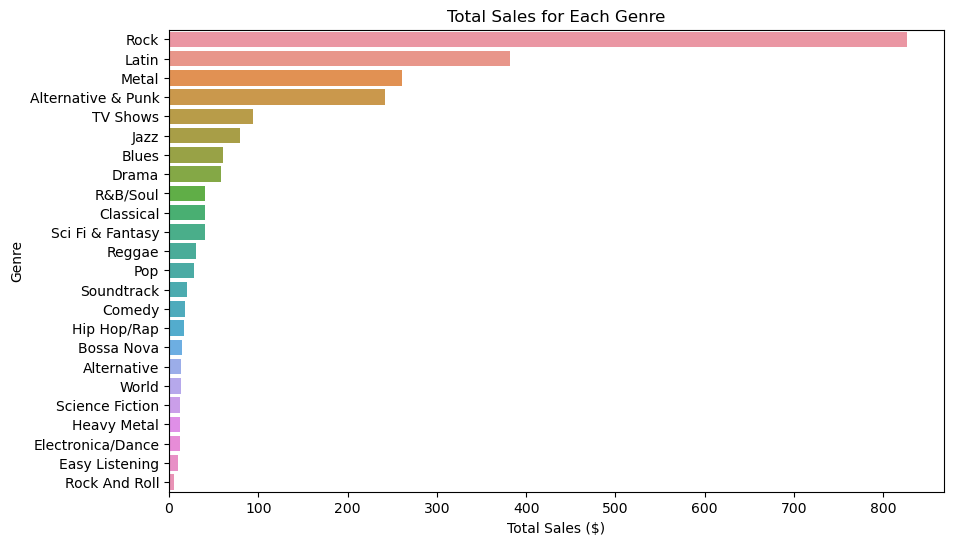

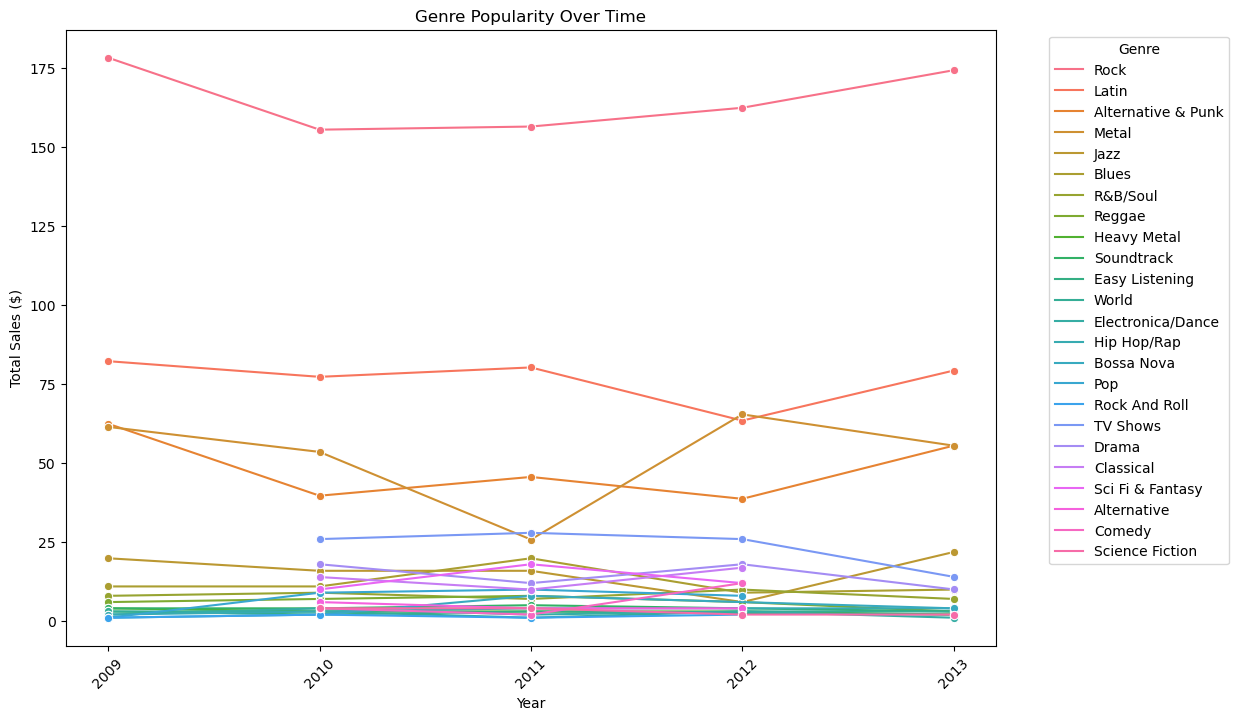

In [15]:
# Visualizing Total Sales for Each Genre 
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_data, x='TotalSales', y='Genre')
plt.title('Total Sales for Each Genre')
plt.xlabel('Total Sales ($)')
plt.ylabel('Genre')
plt.show()

# Visualizing the Genre Popularity Over Time
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_genre_sales_over_time, x='Year', y='TotalSales', hue='Genre', marker='o')
plt.title('Genre Popularity Over Time')
plt.xlabel('Year')
plt.ylabel('Total Sales ($)')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

**Change in top 5 genres popularity over different time periods**

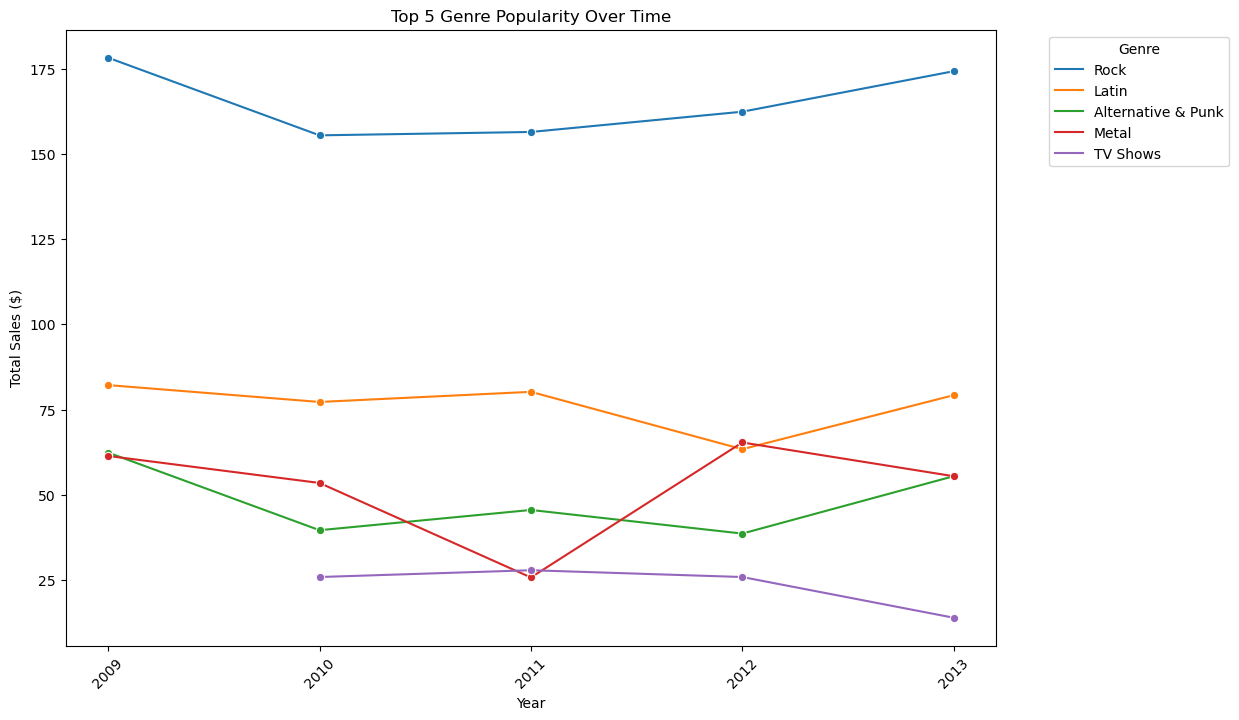

In [16]:
total_sales_by_genre = df_genre_sales_over_time.groupby('Genre')['TotalSales'].sum()

top_five_genres = total_sales_by_genre.nlargest(5).index

# Here; I Filtered the DataFrame to include only the top five genres
top_five_genres_data = df_genre_sales_over_time[df_genre_sales_over_time['Genre'].isin(top_five_genres)]

# Visualizing the top 5 genres
plt.figure(figsize=(12, 8))
sns.lineplot(data=top_five_genres_data, x='Year', y='TotalSales', hue='Genre', marker='o')
plt.title('Top 5 Genre Popularity Over Time')
plt.xlabel('Year')
plt.ylabel('Total Sales ($)')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

**Analysis of No. 3 Use Case.**

From the analysis above, we can see that certain music genres consistently dominate sales, while others experience fluctuations. 

1. Rock and Latin are among the top-selling genres, indicating their enduring popularity.

2. Over the years, genres like Pop and Blues have shown notable increases in sales, suggesting rising interest.

**Use Case 4:**

Sales Over Time: Analyze monthly and yearly sales trends, including seasonal effects and significant sales events.

Monthly Sales Trend Data:
      Month  TotalSales
0  2009-01       35.64
1  2009-02       37.62
2  2009-03       37.62
3  2009-04       37.62
4  2009-05       37.62
Yearly Sales Trend Data:
    Year  TotalSales
0  2009      449.46
1  2010      481.45
2  2011      469.58
3  2012      477.53
4  2013      450.58
Summary Statistics for Monthly Sales Trend:
        TotalSales
count   60.000000
mean    38.810000
std      4.743155
min     23.760000
25%     37.620000
50%     37.620000
75%     37.620000
max     52.620000
Summary Statistics for Yearly Sales Trend:
        TotalSales
count     5.00000
mean    465.72000
std      14.96175
min     449.46000
25%     450.58000
50%     469.58000
75%     477.53000
max     481.45000


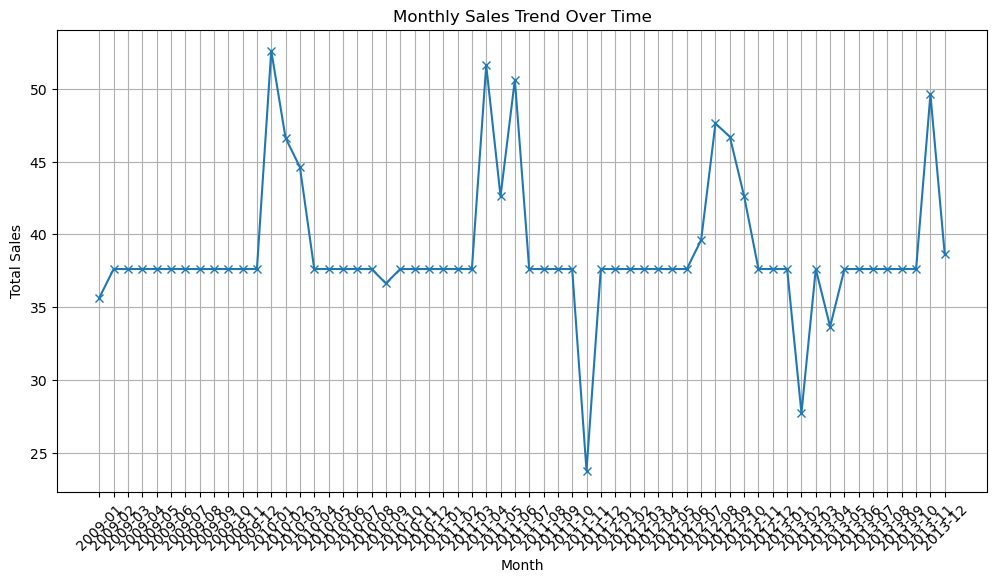

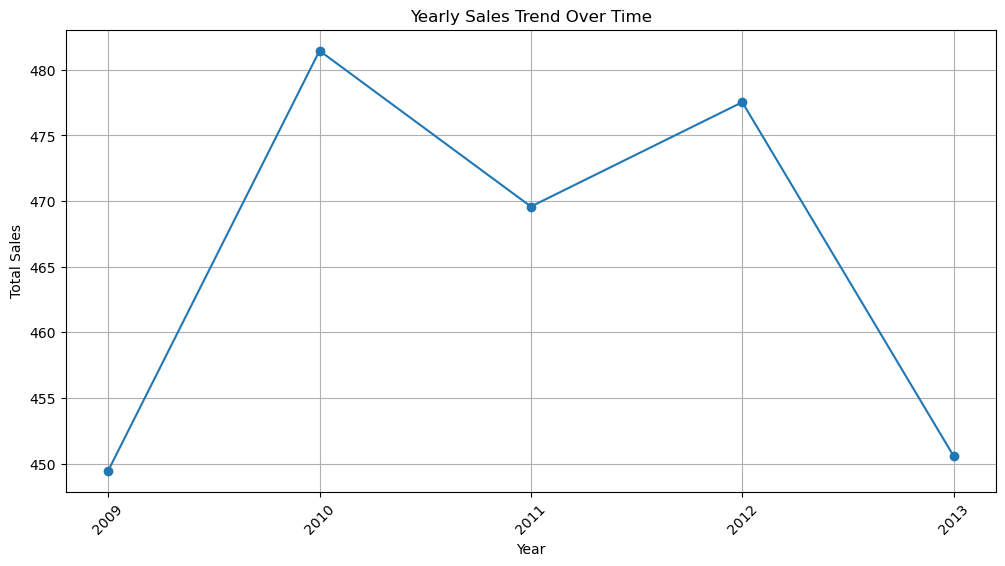

In [17]:
# Connecting my database
Chinook_data = sqlite3.connect(path_to_file)

# Query to get monthly sales trend data
query_monthly = '''
SELECT strftime('%Y-%m', InvoiceDate) AS Month, SUM(Total) AS TotalSales
FROM invoices
GROUP BY Month
ORDER BY Month;
'''

# Query to get yearly sales trend data
query_yearly = '''
SELECT strftime('%Y', InvoiceDate) AS Year, SUM(Total) AS TotalSales
FROM invoices
GROUP BY Year
ORDER BY Year;
'''

# Loading the data into DataFrames
monthly_sales_trend_data = pd.read_sql_query(query_monthly, Chinook_data)
yearly_sales_trend_data = pd.read_sql_query(query_yearly, Chinook_data)

# Closing my connection
Chinook_data.close()

# Printing the DataFrames 
print("Monthly Sales Trend Data:\n", monthly_sales_trend_data.head())
print("Yearly Sales Trend Data:\n", yearly_sales_trend_data.head())

# Printing the summary statistics of both trends
print("Summary Statistics for Monthly Sales Trend:\n", monthly_sales_trend_data.describe())
print("Summary Statistics for Yearly Sales Trend:\n", yearly_sales_trend_data.describe())

# Visualizing the monthly sales trend over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_trend_data['Month'], monthly_sales_trend_data['TotalSales'], marker='x')
plt.title('Monthly Sales Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Visualizing the yearly sales trend over time
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales_trend_data['Year'], yearly_sales_trend_data['TotalSales'], marker='o')
plt.title('Yearly Sales Trend Over Time')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Analysis of No. 4 Use Case.**

The above analysis on the monthly and yearly sales indicate the following: 

Monthly Sales Trend:
1. In 2009, Sales went up in December and January, while the rest of the months remained relatively constant.

2. In 2010, Sales remained constant but went a bit down in August.

3. In 2011, there were lots of fluctuations, but the most significant increase happened in March and May, and decline in October.

4. In 2012, there were lots of fluctuations too but July, and August recorded the highest increase.

5. In 2013, there was a decline in January, and March. Then, increase in October

Yearly Sales Trend:
1. There's steady increase in total sales year-over-year, indicating business growth.

2. Sales peak at the end of each year, showing that holiday season shopping is very important.

Finally, Sales went up and down a little bit over the five years. The highest sales were in 2010 at 481.45, and the lowest were in 2009 at 449.46. But mostly, sales remained consistent.

**Use Case 5.**

Customer Lifetime Value(CLV): Calculate the lifetime value of customers based on their purchase history and provide recommendations for improving customer retention.

In [18]:
# Connecting my database
Chinook_data = sqlite3.connect(path_to_file)

# First, I'll get the customer purchase history data

query = '''
SELECT c.CustomerId, c.FirstName, c.LastName, SUM(i.Total) AS TotalSpent, COUNT(i.InvoiceId) AS PurchaseCount
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY TotalSpent DESC;
'''

# Loading the data into a DataFrame
customer_data = pd.read_sql_query(query, Chinook_data)

# Closing my connection
Chinook_data.close()

# Calculating the average purchase value
customer_data['AvgPurchaseValue'] = customer_data['TotalSpent'] / customer_data['PurchaseCount']

# Calculating the purchase frequency
purchase_frequency = customer_data['PurchaseCount'].sum() / customer_data['CustomerId'].nunique()

# To calculate the CLV, we need a churn rate. Therefore, I'll assume a churn rate of rate of 5%
# The rate of 5% will provide a lower bound estimate for our CLV.
churn_rate = 0.05

# Customer Lifetime Value (CLV):
customer_data['CLV'] = customer_data['AvgPurchaseValue'] * purchase_frequency / churn_rate

# CLV dataframe
print(customer_data.head())

   CustomerId FirstName    LastName  TotalSpent  PurchaseCount  \
0           6    Helena        Holý       49.62              7   
1          26   Richard  Cunningham       47.62              7   
2          57      Luis       Rojas       46.62              7   
3          45  Ladislav      Kovács       45.62              7   
4          46      Hugh    O'Reilly       45.62              7   

   AvgPurchaseValue         CLV  
0          7.088571  989.997094  
1          6.802857  950.093947  
2          6.660000  930.142373  
3          6.517143  910.190799  
4          6.517143  910.190799  


In [19]:
# Summary statistics of CLV
print(customer_data['CLV'].describe())

count     59.000000
mean     789.509703
std       58.205848
min      750.578208
25%      750.578208
50%      750.578208
75%      800.457143
max      989.997094
Name: CLV, dtype: float64


**Visual Representation**

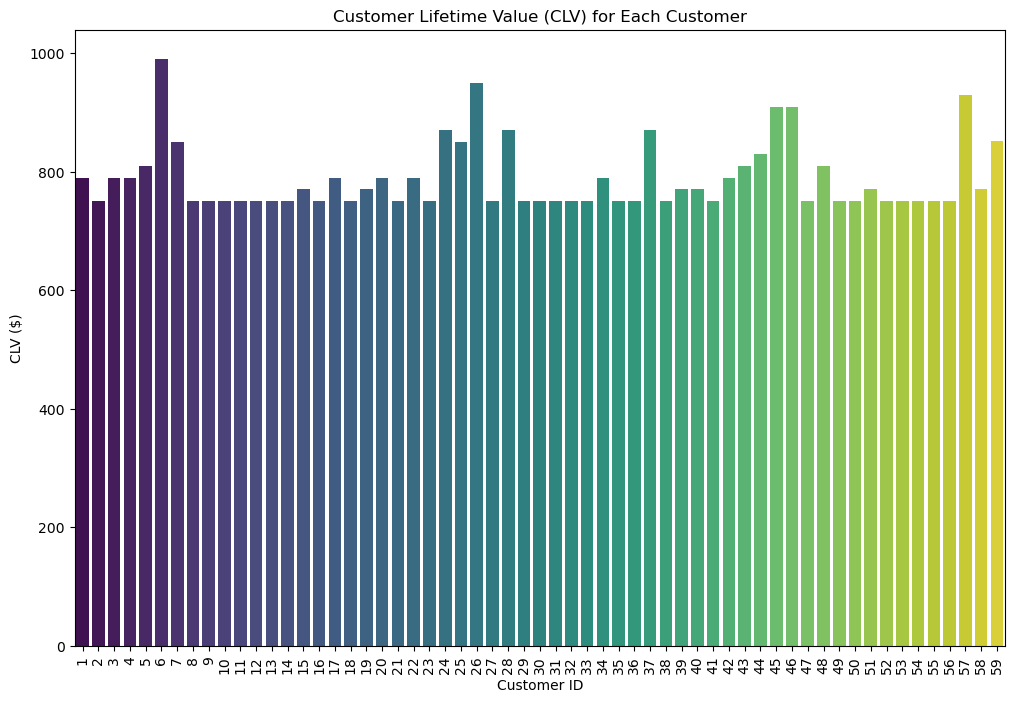

In [20]:
# Plotting the CLV using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=customer_data, x='CustomerId', y='CLV', palette='viridis')
plt.title('Customer Lifetime Value (CLV) for Each Customer')
plt.xlabel('Customer ID')
plt.ylabel('CLV ($)')
plt.xticks(rotation=90)
plt.show()

**Analysis of No. 5 Use Case.**

First, Customer Lifetime Value (CLV) shows how much money each customer is expected to bring to the company over their entire relationship.

In our analysis, Some customers have very high CLV, such as the top 5 who collectively contribute significantly more to sales than others.

Also, there are customers that have low CLV, meaning they don't spend much or buy often.

**Recommendations For Improving Customers Retention.**

1. Rewarding loyal customers: Top customers with high CLV, can be encouraged to continue their spending with special offers, and discounts.
    
2. Improving the engagements with low CLV customers: By reaching out to customers who haven't purchased in a while with special deals or reminders, we can reactivate these customers and boost their CLV.
    
3. Improving on the customer service and feedback collection

4. Personalized Marketing: Use the CLV data to identify high-value customers and target them with personalized marketing campaigns

**Use Case 6:**
    
Market Basket Analysis: Perform association rule mining to find common combination of tracks or albums purchased together.

In [21]:
Chinook_data = sqlite3.connect(path_to_file)

# Understanding track purchase data with genre information
query = '''
SELECT i.InvoiceId, g.Name AS GenreName
FROM invoice_items ii
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums a ON t.AlbumId = a.AlbumId
JOIN genres g ON t.GenreId = g.GenreId
JOIN invoices i ON ii.InvoiceId = i.InvoiceId
'''

# Loading the data into a DataFrame
track_data = pd.read_sql_query(query, Chinook_data)

# Closing my connection
Chinook_data.close()

# Printing my DataFrame
print(track_data.head())
print(track_data.info())

   InvoiceId GenreName
0          1      Rock
1          1      Rock
2          2      Rock
3          2      Rock
4          2      Rock
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   InvoiceId  2240 non-null   int64 
 1   GenreName  2240 non-null   object
dtypes: int64(1), object(1)
memory usage: 35.1+ KB
None


To perform the market basket analysis, we'll use the mixtend library. Therefore, we'll import TransactionEncoder and apriori, association_rules.

Firstly, we'll use the TransactionEncoder to convert transaction data into a binary matrix format.

Secondly, we'll apply the apriori function to find frequent itemsets in your data.

Thirdly, we'll use the association_rules function to generate rules from these frequent itemsets.

In [22]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Grouping the data by InvoiceId to create a list of lists for each transaction based on genres
transactions = track_data.groupby('InvoiceId')['GenreName'].apply(list).tolist()
print(transactions[:5])  # Display the first 5 transactions

# Using TransactionEncoder to transform the data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Printing the transformed DataFrame
print(df.head())

[['Rock', 'Rock'], ['Rock', 'Rock', 'Rock', 'Rock'], ['Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock'], ['Rock', 'Rock', 'Rock', 'Rock', 'Jazz', 'Jazz', 'Metal', 'Metal', 'Rock'], ['Alternative & Punk', 'Alternative & Punk', 'Rock And Roll', 'Jazz', 'Metal', 'Metal', 'Metal', 'Metal', 'Alternative & Punk', 'Alternative & Punk', 'Metal', 'Blues', 'Latin', 'Latin']]
   Alternative  Alternative & Punk  Blues  Bossa Nova  Classical  Comedy  \
0        False               False  False       False      False   False   
1        False               False  False       False      False   False   
2        False               False  False       False      False   False   
3        False               False  False       False      False   False   
4        False                True   True       False      False   False   

   Drama  Easy Listening  Electronica/Dance  Heavy Metal  ...    Pop  \
0  False           False              False        False  ...  False   
1  False           False         

In [23]:
# Applying the Apriori algorithm to find frequent itemsets with a lower min_support.(I assumed a min_support of 0.01 to include even the less frequent ones)
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)
print(frequent_itemsets)  # To check if there are any frequent itemsets found

# Generating association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Printing the rules
print(rules.head())

     support                                 itemsets
0   0.225728                     (Alternative & Punk)
1   0.065534                                  (Blues)
2   0.016990                             (Bossa Nova)
3   0.036408                              (Classical)
4   0.012136                                 (Comedy)
..       ...                                      ...
76  0.014563                (Metal, Soundtrack, Rock)
77  0.016990                     (Metal, World, Rock)
78  0.012136  (Latin, Alternative & Punk, Rock, Jazz)
79  0.012136         (Metal, Latin, Soundtrack, Rock)
80  0.016990              (Metal, Latin, World, Rock)

[81 rows x 2 columns]
            antecedents           consequents  antecedent support  \
0               (Blues)  (Alternative & Punk)            0.065534   
1  (Alternative & Punk)               (Blues)            0.225728   
2  (Alternative & Punk)                (Jazz)            0.225728   
3                (Jazz)  (Alternative & Punk)        

In [24]:
# Sorting the frequent itemsets by support in descending order
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

# Filtering for itemsets with more than one genre
multi_genre_itemsets = frequent_itemsets_sorted[frequent_itemsets_sorted['itemsets'].apply(lambda x: len(x) > 1)]

# Extracting the top 5 most common combinations
top_5_combinations = multi_genre_itemsets.head(5)

# Printing the results of the top 5 most common genre combinations
print("Top 5 most common genre combinations:")
for idx, row in top_5_combinations.iterrows():
    genres = ', '.join(sorted(list(row['itemsets'])))
    support = row['support']
    print(f"{genres}: {support:.4f}")

Top 5 most common genre combinations:
Alternative & Punk, Rock: 0.1311
Latin, Rock: 0.1238
Metal, Rock: 0.1117
Latin, Metal: 0.0607
Jazz, Rock: 0.0583


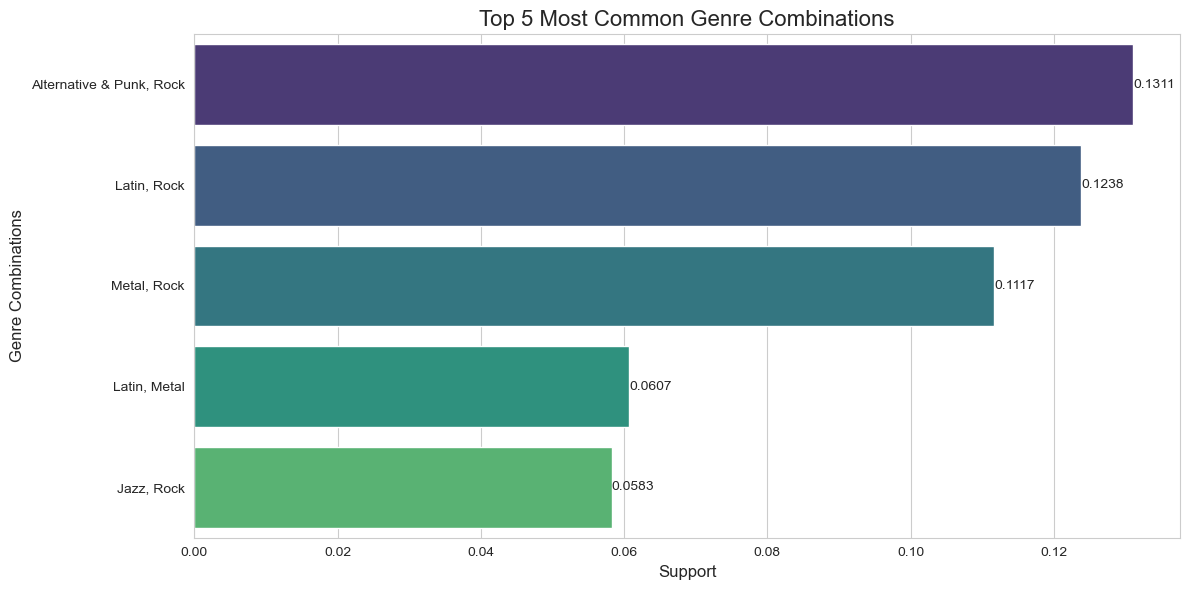

In [25]:
# Preparing data for plotting
genres = [', '.join(sorted(list(x))) for x in top_5_combinations['itemsets']]
supports = top_5_combinations['support']

# Setting up the plot style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.set_palette("viridis")

# Creating the bar plot
ax = sns.barplot(x=supports, y=genres, orient='h')

# Customizing the plot
plt.title("Top 5 Most Common Genre Combinations", fontsize=16)
plt.xlabel("Support", fontsize=12)
plt.ylabel("Genre Combinations", fontsize=12)

# Adding value labels to the end of each bar
for i, v in enumerate(supports):
    ax.text(v, i, f'{v:.4f}', va='center', fontsize=10)

# Adjusting layout and printing the plot
plt.tight_layout()
plt.show()

Our analysis identified that;

1. Alternative & Punk and Rock, Metal & Rock, Latin & Rock, Latin & Metal, and Jazz & Rock are the top 5 most common combinations of genre.

2. People who like Alternative & Punk music really like Rock too. More than half (about 58%) of those who buy Alternative & Punk also buy Rock. And a quarter (25%) of Rock buyers also get some Alternative & Punk music.

3. Jazz and Rock fans often like both kinds of music. If someone buys Jazz music, there's a good chance (about 59%) they'll buy Rock too. But if someone buys Rock, they're less likely (only about 11%) to also buy Jazz.

**Most common combinations of Albums**

In [26]:
Chinook_data = sqlite3.connect(path_to_file)

# Most common combinations of Albums
query = '''
SELECT i.InvoiceId, a.Title AS AlbumTitle, t.Name AS TrackName
FROM invoice_items ii
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums a ON t.AlbumId = a.AlbumId
JOIN invoices i ON ii.InvoiceId = i.InvoiceId
'''

# Loading the data into a DataFrame
track_data = pd.read_sql_query(query, Chinook_data)

# Closing the connection
Chinook_data.close()

In [27]:
# Grouping the data by InvoiceId to create a list of lists for each transaction based on track names
transactions = track_data.groupby('InvoiceId')['AlbumTitle'].apply(list).tolist()
print(transactions[:5])  # Display the first 5 transactions

# Using TransactionEncoder to transform the data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Display the transformed DataFrame
print(df.head())

[['Balls to the Wall', 'Restless and Wild'], ['For Those About To Rock We Salute You', 'For Those About To Rock We Salute You', 'For Those About To Rock We Salute You', 'For Those About To Rock We Salute You'], ['Let There Be Rock', 'Let There Be Rock', 'Big Ones', 'Big Ones', 'Big Ones', 'Big Ones'], ['Jagged Little Pill', 'Jagged Little Pill', 'Facelift', 'Facelift', 'Warner 25 Anos', 'Warner 25 Anos', 'Plays Metallica By Four Cellos', 'Plays Metallica By Four Cellos', 'Audioslave'], ['Out Of Exile', 'Out Of Exile', 'BackBeat Soundtrack', 'The Best Of Billy Cobham', 'Alcohol Fueled Brewtality Live! [Disc 1]', 'Alcohol Fueled Brewtality Live! [Disc 2]', 'Black Sabbath', 'Black Sabbath Vol. 4 (Remaster)', 'Body Count', 'Body Count', 'Chemical Wedding', 'The Best Of Buddy Guy - The Millenium Collection', 'Prenda Minha', 'Prenda Minha']]
   ...And Justice For All  \
0                   False   
1                   False   
2                   False   
3                   False   
4      

In [28]:
# Applying the Apriori algorithm to find frequent itemsets with a lower min_support of 0.002.
# Because of high volume of data, higher support values aren't outputting anything & lower couldn't load.

frequent_itemsets = apriori(df, min_support=0.002, use_colnames=True)
print(frequent_itemsets)  # Check if there are any frequent itemsets found

# Generating association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Printing the rules
print(rules.head())

        support                                           itemsets
0      0.009709                           (...And Justice For All)
1      0.007282  (20th Century Masters - The Millennium Collect...
2      0.009709                       (A Matter of Life and Death)
3      0.009709                                  (A Real Dead One)
4      0.009709                                  (A Real Live One)
...         ...                                                ...
62660  0.002427  (Stormbringer, Outbreak, Come Taste The Band, ...
62661  0.002427  (Stormbringer, Outbreak, Come Taste The Band, ...
62662  0.002427  (Stormbringer, Outbreak, Knocking at Your Back...
62663  0.002427  (No Prayer For The Dying, Fear Of The Dark, Ki...
62664  0.002427  (Stormbringer, Outbreak, Come Taste The Band, ...

[62665 rows x 2 columns]
                                    antecedents               consequents  \
0                               (Ace Of Spades)  (...And Justice For All)   
1               

In [29]:
# Sorting the frequent itemsets by support in descending order
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

# Filtering for itemsets with more than one album
multi_album_itemsets = frequent_itemsets_sorted[frequent_itemsets_sorted['itemsets'].apply(lambda x: len(x) > 1)]

# Extracting the top 5 most common combinations
top_5_combinations = multi_album_itemsets.head(5)

print(top_5_combinations)

       support                                           itemsets
1971  0.009709  (The Essential Miles Davis [Disc 1], The Essen...
1917  0.009709  (Supernatural, The Essential Miles Davis [Disc...
1681  0.009709             (Nevermind, Motley Crue Greatest Hits)
1653  0.009709                   (Minha Historia, Minha História)
1925  0.009709      (The Return Of The Space Cowboy, Synkronized)


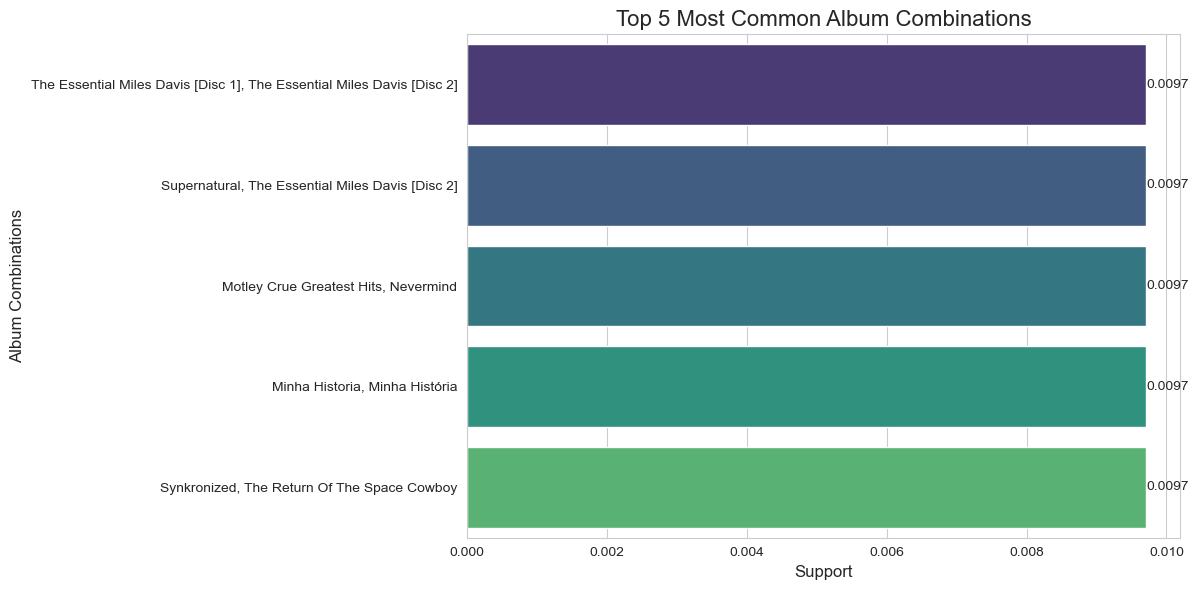

In [30]:
# Visualizing the top 5 most common album combinations
albums = [', '.join(sorted(list(x))) for x in top_5_combinations['itemsets']]
supports = top_5_combinations['support']

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.set_palette("viridis")

ax = sns.barplot(x=supports, y=albums, orient='h')
plt.title("Top 5 Most Common Album Combinations", fontsize=16)
plt.xlabel("Support", fontsize=12)
plt.ylabel("Album Combinations", fontsize=12)

for i, v in enumerate(supports):
    ax.text(v, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

**Most Common Tracks Combinations**

In [31]:
Chinook_data = sqlite3.connect(path_to_file)

# Query to get track names instead of album titles
query = '''
SELECT i.InvoiceId, t.Name AS TrackName
FROM invoice_items ii
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN invoices i ON ii.InvoiceId = i.InvoiceId
'''

# Loading the data into a DataFrame
track_data = pd.read_sql_query(query, Chinook_data)

# Closing the connection
Chinook_data.close()

In [32]:
# Grouping the data by InvoiceId to create a list of lists for each transaction based on track names
transactions = track_data.groupby('InvoiceId')['TrackName'].apply(list).tolist()
print(transactions[:5])  # Display the first 5 transactions

# Using TransactionEncoder to transform the data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Printing the transformed DataFrame
print(df.head())

[['Balls to the Wall', 'Restless and Wild'], ['Put The Finger On You', 'Inject The Venom', 'Evil Walks', 'Breaking The Rules'], ['Dog Eat Dog', 'Overdose', 'Love In An Elevator', "Janie's Got A Gun", 'Deuces Are Wild', 'Angel'], ['Right Through You', 'Not The Doctor', 'Bleed The Freak', 'Confusion', 'Por Causa De Você', 'Angela', 'Master Of Puppets', 'Welcome Home (Sanitarium)', 'Set It Off'], ['Your Time Has Come', 'Dandelion', "Rock 'N' Roll Music", 'Moon germs', 'Super Terrorizer', 'Heart Of Gold', 'Evil Woman', 'Cornucopia', 'Bowels Of The Devil', 'Body Count Anthem', 'Jerusalem', 'When My Left Eye Jumps', 'Meditação', 'Esse Cara']]
     "?"  #9 Dream  'Round Midnight  (Anesthesia) Pulling Teeth  \
0  False     False            False                       False   
1  False     False            False                       False   
2  False     False            False                       False   
3  False     False            False                       False   
4  False     False  

In [34]:
# Applying the Apriori algorithm to find frequent itemsets with a lower min_support. 
# Here, I used min_support of 0.004 because it's the lowest number that can work for me.
frequent_itemsets = apriori(df, min_support=0.004, use_colnames=True)
print(frequent_itemsets)  # Check if there are any frequent itemsets found

# Generating association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Printing the rules
print(rules.head())

      support                                           itemsets
0    0.007282                            (2 Minutes To Midnight)
1    0.004854                                     (A Cor Do Sol)
2    0.004854                                   (A Melhor Forma)
3    0.004854                                (A Novidade (Live))
4    0.004854                         (Abraham, Martin And John)
..        ...                                                ...
401  0.004854  (Menestrel Das Alagoas, Norwegian Wood, The Duke)
402  0.004854  (Por Causa De Você, Welcome Home (Sanitarium),...
403  0.004854            (Right On Time, Under The Bridge, Tear)
404  0.004854          (Train In Vain, Sun King, Speed Of Light)
405  0.004854               (Walkabout, The Fix, The Woman King)

[406 rows x 2 columns]
                   antecedents         consequents  antecedent support  \
0               (A Cor Do Sol)  (Linha Do Equador)            0.004854   
1           (Linha Do Equador)      (A Cor Do So

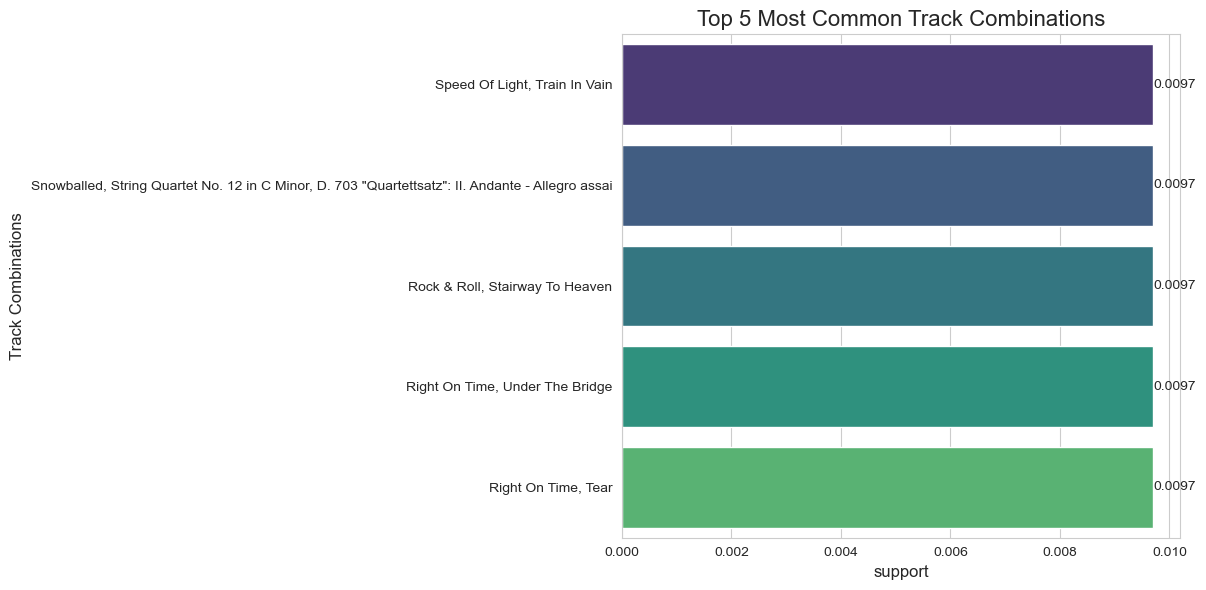

In [35]:
# Sorting the frequent itemsets by support in descending order
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

# Filtering for itemsets with more than one track
multi_track_itemsets = frequent_itemsets_sorted[frequent_itemsets_sorted['itemsets'].apply(lambda x: len(x) > 1)]

# Extracting the top 5 most common combinations
top_5_combinations = multi_track_itemsets.head(5)

# Ensuring that there are itemsets to plot
if not top_5_combinations.empty:
    # Preparing data for plotting
    tracks = [', '.join(sorted(list(x))) for x in top_5_combinations['itemsets']]
    support = top_5_combinations['support']

    # Setting up the plot style
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("viridis")

    # Creating the bar plot
    ax = sns.barplot(x=supports, y=tracks, orient='h')

    # Customizing the plot
    plt.title("Top 5 Most Common Track Combinations", fontsize=16)
    plt.xlabel("support", fontsize=12)
    plt.ylabel("Track Combinations", fontsize=12)

    # Adding value labels to the end of each bar
    for i, v in enumerate(supports):
        ax.text(v, i, f'{v:.4f}', va='center', fontsize=10)

    # Adjusting layout and display the plot
    plt.tight_layout()
    plt.show()
else:
    print("No common track combinations found.")

**Brief Explanations of the Association Rules Metrics.**

Primary Metrics: 
    
The primary metrics used in association rule mining are support, confidence, and lift.

1. **Support:** The proportion of transactions in the dataset that contain the itemset. It measures how frequently an itemset appears in the dataset.
    
2. **Confidence:** The likelihood of item B being purchased when item A is purchased. It measures the reliability of the inference made by the rule.
    
3. **Lift:** The ratio of the observed support to that expected if A and B were independent. It measures how much more likely item B is to be purchased when item A is purchased.
    
Additional Metrics:
    
**Leverage:** The difference between the observed support and the expected support if A and B were independent.
    
**Conviction:** The ratio of the expected frequency of A occurring without B if A and B were independent to the observed frequency of A occurring without B.

**Summary of Analysis of Use Case 6**
    
Our analysis on Albums and Tracks combinations identified that;

1. For Album combinations, the top 5 common combinations are; The Essential Miles Davis[Disc 1] & The Essential Miles Davis[Disc 2], Supernatural & The Essential Miles Davis [Disc 2], Motley Crue Greatest Hits & Nevermind, Minha Historia & Minha Historia, Synkronized & The Return of the Space Cowboy.



2. For Track Combinations, the top 5 common combinations are; Speed of Light & Train in Vain, Snowballed & String Quartet No. 12 in C Minor & D.703 "Quartettsatz": II. Andante - Allegro assai, Rock and Roll & Stairway to Heaven, Right on time & Under the Bridge, Right on time & Tear.

However, the dataset may have many unique combinations, but none of them occur frequently enough to create significant differentiation in support or other metrics.

I got to this conclusion because I tried so many minimum support in my Apriori algorithm calculations but it's not working. I tried using below 0.002 but I had memory issue, then above the minimum support I used outputted empty values. Hence my conclusion on sparse dataset.

**Recommendation**

To improve sales strategies and customer experience, 

1. Bundle tracks or albums from genres that are frequently purchased together to encourage customers to buy more items at once.
Also, offer discounts or special deals on these bundles to make them more attractive to customers.
    
2. When a customer purchases a track or album, recommend related tracks or genres that are often bought together.
    
3. Continuously monitor sales data and adjust your strategies based on new patterns and trends. Use ongoing market basket analysis to stay informed about changing customer preferences.

4. Collect feedback from customers about the effectiveness of promotional bundles and recommendations to refine your approach.

**Overall Analysis Of Chinook Database Analysis:**
    
**Key Findings:**
    
1. Sales Performance: Consistent overall, with slight fluctuations 

2. Genre Dominance: Rock leads, followed by Latin and Metal 

3. Artist Impact: Top 5 artists contribute significantly to total sales 

4. Customer Base: The majority are low-value, but a quarter are high-value
 
5. Strong Customer Loyalty: 100% retention rate 

6. Top Customers: Helena Holy, Richard Cunningham, Luis Rojas, Ladislav Kovacs, and Hugh O'Reilly

7. Popular Genre Combinations: Rock is  frequently paired with Alternative & Punk, Latin, and Meta

**Recommendations:**
    
1. Invest in Top-Selling Artists

2. Analyse sales patterns

3. Prioritize popular genres

4. Enhance customer engagement

5. Maintain high retention

6. Leverage customer insights

7. VIP Customer Program: Implement an exclusive program for top customers like Helena Holy, Richard Cunningham, and Luis Rojas.

8. Cross-Genre Marketing Strategy: Develop campaigns highlighting connections between rock and its popular pairings (Alternative & Punk, Latin, and Metal).
